In [1]:
import tensorflow as tf  
 
# Display the version
print(tf.__version__)    
 
# other imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Reshape, Add
from tensorflow.keras.layers import Layer, Softmax, ReLU
from tensorflow.keras.models import Model

2.9.2


In [2]:
class KDRightLayer(Layer):
  def __init__(self,n,activation=None):
    super(KDRightLayer, self).__init__()
    self.n = n
    self.activation = tf.keras.activations.get(activation)

  def build(self, input_shape):
    self.q = input_shape[1]
    self.m = input_shape[2]
    # initialize the weights
    w_init = tf.random_normal_initializer()
    self.w = tf.Variable(name="kernel", initial_value=w_init(shape=(self.m, self.n),
                         dtype='float32'),trainable=True)
    # initialize the biases
    b_init = tf.zeros_initializer()
    self.b = tf.Variable(name="bias",initial_value=b_init(shape=(self.q,self.n), dtype='float32'),
                         trainable=True)

  def call(self, inputs):
    return self.activation(tf.matmul(inputs, self.w) + self.b)

In [3]:
class KDLeftLayer(Layer):
  def __init__(self,m,activation=None):
    super(KDLeftLayer, self).__init__()
    self.m = m
    self.activation = tf.keras.activations.get(activation)

  def build(self, input_shape):
    self.n = input_shape[1]
    self.p = input_shape[2]
    # initialize the weights
    w_init = tf.random_normal_initializer()
    self.w = tf.Variable(name="kernel", initial_value=w_init(shape=(self.m, self.n),
                                                             dtype='float32'),trainable=True)
    # initialize the biases
    b_init = tf.zeros_initializer()
    self.b = tf.Variable(name="bias",initial_value=b_init(shape=(self.m,self.p), 
                                                          dtype='float32'),trainable=True)

  def call(self, inputs):
    # return self.activation(tf.matmul(self.w,inputs) + self.b) # doesn't work with SGD unless batch size = 1
    # (inputs^T * self.w^T)^T = self.w * inputs
    return self.activation(tf.transpose(tf.matmul(tf.transpose(inputs,perm=[0, 2, 1]),
                                                  tf.transpose(self.w)),perm=[0, 2, 1]) + self.b)

In [4]:
# Load cifar10
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [5]:
# Normalize
x_train, x_test = x_train / 255.0, x_test / 255.0
 
# Flatten the label values
y_train, y_test = y_train.flatten(), y_test.flatten()

In [6]:
# Build the KDL model using the functional API
# input layer
i = Input(shape=x_train[0].shape)

# Convolution Layers
x = Conv2D(16, (3, 3), activation='relu', padding='same')(i)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Dropout
x = Dropout(0.2)(x)
x = Reshape((64,64))(x)
 
# KDL layers
x = KDLeftLayer(64, activation='relu')(x)
x = KDRightLayer(64, activation='relu')(x)

x = KDLeftLayer(64, activation='relu')(x)
x = KDRightLayer(64, activation='relu')(x)
 
# Another set of KDL layers for output
x = KDLeftLayer(2, activation='relu')(x)
x = KDRightLayer(5)(x)
x = Flatten()(x)
x = Softmax()(x)

# Build model
model = Model(i, x)
 
# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         147712

In [7]:
# Compile with learning rate 0.005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [8]:
# Training
hist_KDL = model.fit(x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
391/391 [==============================] - 161s 408ms/step - loss: 1.9431 - accuracy: 0.2718 - val_loss: 1.6419 - val_accuracy: 0.3978
Epoch 2/20
391/391 [==============================] - 156s 399ms/step - loss: 1.4702 - accuracy: 0.4642 - val_loss: 1.3344 - val_accuracy: 0.5094
Epoch 3/20
391/391 [==============================] - 159s 407ms/step - loss: 1.2711 - accuracy: 0.5409 - val_loss: 1.1472 - val_accuracy: 0.5871
Epoch 4/20
391/391 [==============================] - 155s 396ms/step - loss: 1.1110 - accuracy: 0.6028 - val_loss: 1.0482 - val_accuracy: 0.6266
Epoch 5/20
391/391 [==============================] - 161s 413ms/step - loss: 1.0168 - accuracy: 0.6387 - val_loss: 0.9779 - val_accuracy: 0.6559
Epoch 6/20
391/391 [==============================] - 159s 406ms/step - loss: 0.9405 - accuracy: 0.6686 - val_loss: 0.9507 - val_accuracy: 0.6627
Epoch 7/20
391/391 [==============================] - 158s 404ms/step - loss: 0.8702 - accuracy: 0.6937 - val_loss: 0.9085 -

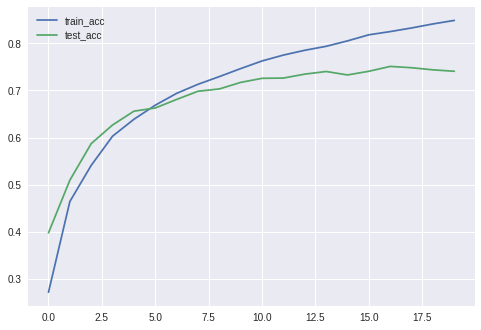

In [9]:
# Plot training and test accuracy
plt.style.use('seaborn')
plt.plot(hist_KDL.history['accuracy'], label='train_acc', color='C0')
plt.plot(hist_KDL.history['val_accuracy'], label='test_acc', color='C1')
plt.legend()

In [10]:
# Build the dense model using the functional API
# input layer
i = Input(shape=x_train[0].shape)

# Convolution Layer
x = Conv2D(16, (3, 3), activation='relu', padding='same')(i)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Dropout Layer
x = Dropout(0.2)(x)
x = Flatten()(x)
 
# Dense layers
x = Dense(4096, activation='relu')(x)

x = Dense(4096, activation='relu')(x)
 
# For output
x = Dense(10, activation='softmax')(x)

# Build model
model = Model(i, x)
 
# model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        9280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 256)         1477

In [11]:
# Compile with learning rate 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [12]:
hist_dense = model.fit(
  x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
391/391 [==============================] - 575s 1s/step - loss: 1.5557 - accuracy: 0.4280 - val_loss: 1.3141 - val_accuracy: 0.5125
Epoch 2/20
391/391 [==============================] - 585s 1s/step - loss: 1.0860 - accuracy: 0.6095 - val_loss: 0.9313 - val_accuracy: 0.6714
Epoch 3/20
391/391 [==============================] - 583s 1s/step - loss: 0.8867 - accuracy: 0.6879 - val_loss: 0.8966 - val_accuracy: 0.6834
Epoch 4/20
391/391 [==============================] - 588s 2s/step - loss: 0.7523 - accuracy: 0.7350 - val_loss: 0.8148 - val_accuracy: 0.7151
Epoch 5/20
391/391 [==============================] - 585s 1s/step - loss: 0.6326 - accuracy: 0.7773 - val_loss: 0.7705 - val_accuracy: 0.7347
Epoch 6/20
391/391 [==============================] - 581s 1s/step - loss: 0.5331 - accuracy: 0.8108 - val_loss: 0.7344 - val_accuracy: 0.7522
Epoch 7/20
391/391 [==============================] - 577s 1s/step - loss: 0.4442 - accuracy: 0.8423 - val_loss: 0.7637 - val_accuracy: 0.7506

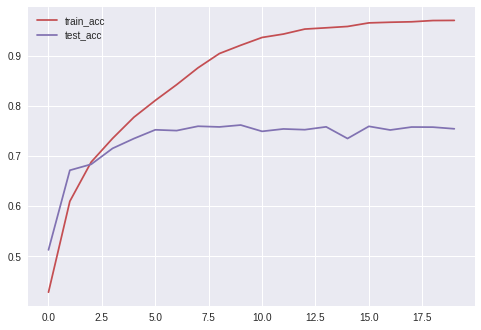

In [13]:
# Plot training and test accuracy
plt.plot(hist_dense.history['accuracy'], label='train_acc', color='C2')
plt.plot(hist_dense.history['val_accuracy'], label='test_acc', color='C3')
plt.legend()

In [14]:
# Build a KDL model with Kronecker rank of 4
# input layer
i = Input(shape=x_train[0].shape)

# Convolution Layer
x = Conv2D(16, (3, 3), activation='relu', padding='same')(i)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Dropout Layer
x = Dropout(0.2)(x)
x = Reshape((64,64))(x)
 
# KDL's (Kronecker rank 4)
x1 = KDLeftLayer(64, activation='relu')(x)
x1 = KDRightLayer(64)(x1)

x2 = KDRightLayer(64, activation='relu')(x)
x2 = KDLeftLayer(64)(x2)

x3 = KDLeftLayer(64, activation='relu')(x) 
x3 = KDRightLayer(64)(x3)

x4 = KDLeftLayer(64, activation='relu')(x)
x4 = KDRightLayer(64)(x4)
 
x = Add()([x1,x2,x3,x4]) # Combine layers before activation
x = ReLU()(x)

x1 = KDLeftLayer(64, activation='relu')(x)
x1 = KDRightLayer(64)(x1)

x2 = KDRightLayer(64, activation='relu')(x)
x2 = KDLeftLayer(64)(x2)

x3 = KDLeftLayer(64, activation='relu')(x) 
x3 = KDRightLayer(64)(x3)

x4 = KDLeftLayer(64, activation='relu')(x)
x4 = KDRightLayer(64)(x4)
 
x = Add()([x1,x2,x3,x4]) 
x = ReLU()(x)

# Another set of KDL's for output (Also Kronecker rank 4)
x1 = KDLeftLayer(2, activation='relu')(x)
x1 = KDRightLayer(5)(x1)

x2 = KDRightLayer(5, activation='relu')(x)
x2 = KDLeftLayer(2)(x2)

x3 = KDLeftLayer(2, activation='relu')(x)
x3 = KDRightLayer(5)(x3)

x4 = KDLeftLayer(2, activation='relu')(x)
x4 = KDRightLayer(5)(x4)

x = Add()([x1,x2,x3,x4])
x = Flatten()(x)
x = Softmax()(x)
model = Model(i, x)
 
# model description
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 16)   448         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 16)  0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 16, 16, 64)   9280        ['max_pooling2d_6[0][0]']        
                                                                                            

In [15]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
hist_KDL4 = model.fit(
  x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
391/391 [==============================] - 218s 550ms/step - loss: 1.8207 - accuracy: 0.3270 - val_loss: 1.4929 - val_accuracy: 0.4522
Epoch 2/20
391/391 [==============================] - 211s 540ms/step - loss: 1.3744 - accuracy: 0.4979 - val_loss: 1.2344 - val_accuracy: 0.5602
Epoch 3/20
391/391 [==============================] - 204s 521ms/step - loss: 1.1733 - accuracy: 0.5769 - val_loss: 1.0991 - val_accuracy: 0.5993
Epoch 4/20
391/391 [==============================] - 211s 540ms/step - loss: 1.0302 - accuracy: 0.6305 - val_loss: 0.9866 - val_accuracy: 0.6479
Epoch 5/20
391/391 [==============================] - 210s 538ms/step - loss: 0.9297 - accuracy: 0.6683 - val_loss: 0.9613 - val_accuracy: 0.6629
Epoch 6/20
391/391 [==============================] - 204s 522ms/step - loss: 0.8508 - accuracy: 0.6997 - val_loss: 0.8646 - val_accuracy: 0.6905
Epoch 7/20
391/391 [==============================] - 211s 540ms/step - loss: 0.7850 - accuracy: 0.7236 - val_loss: 0.8434 -

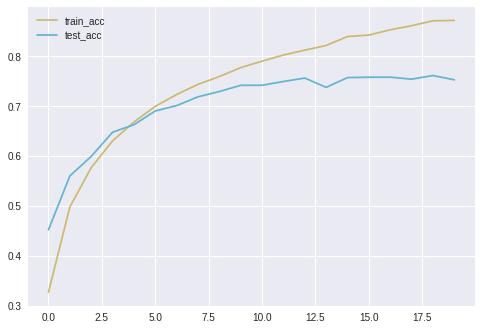

In [17]:
# Plot training and test accuracy
plt.plot(hist_KDL4.history['accuracy'], label='train_acc', color='C4')
plt.plot(hist_KDL4.history['val_accuracy'], label='test_acc', color='C5')
plt.legend()

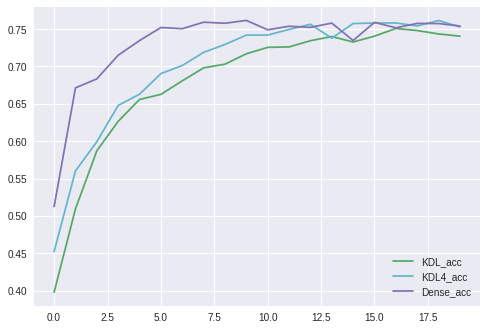

In [18]:
# Plot test accuracy comparison
plt.plot(hist_KDL.history['val_accuracy'], label='KDL_acc', color='C1')
plt.plot(hist_KDL4.history['val_accuracy'], label='KDL4_acc', color='C5')
plt.plot(hist_dense.history['val_accuracy'], label='Dense_acc', color='C3')
plt.legend()